In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import wrangle
import acquire

from scipy import stats
from math import sqrt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 


In [2]:
#Using my acquire.py module, the function new_zillow_data brings in a df that contains:
#columns for single unit properties from 2017 that have had a transaction from May-Aug.
#single unit properties have been defined as: 
#residential single family homes, townhouse, bungalow, and patio homes
#determined based on likliehood of entire unit and property lot/land being owned and used for 
#single owner residential use.
#this dataframe is located in the Codeup SQL database.

df = acquire.new_zillow_data()
df.head()

,parcelid,airconditioningtypeid,heatingorsystemtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,...,poolcnt,propertylandusetypeid,regionidneighborhood,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt,numberofstories,taxamount,taxvaluedollarcnt
0,11721753,NaN,7.0,NaN,NaN,2.0,3.0,1316.0,6037.0,NaN,...,NaN,261.0,268581.0,NaN,NaN,1.0,1923.0,NaN,2627.48,205123.0
1,11289917,1.0,2.0,NaN,NaN,2.0,3.0,1458.0,6037.0,NaN,...,1.0,261.0,NaN,NaN,NaN,1.0,1970.0,NaN,2319.90,136104.0
2,11705026,NaN,2.0,NaN,NaN,1.0,2.0,1421.0,6037.0,NaN,...,NaN,261.0,118208.0,NaN,NaN,1.0,1911.0,NaN,543.69,35606.0
3,14269464,NaN,NaN,NaN,NaN,3.0,4.0,2541.0,6059.0,NaN,...,NaN,261.0,NaN,NaN,NaN,NaN,2003.0,NaN,9819.72,880456.0
4,11446756,NaN,7.0,NaN,NaN,2.0,3.0,1491.0,6037.0,NaN,...,NaN,261.0,274750.0,NaN,NaN,1.0,1955.0,NaN,1399.27,107110.0


In [3]:
df.shape

(28127, 22)

### The goal of this project is to determine the features that are the biggest predictors of 'taxvaluedollarcnt', aka home value.



In [4]:
#Take a look at datatypes
df.info()

#Looking at this info, the fips code column should not be a float. Also, FIPS codes should all begin with a leading zero.
#Year built also should not be float value.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28127 entries, 0 to 28126
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28127 non-null  int64  
 1   airconditioningtypeid         7306 non-null   float64
 2   heatingorsystemtypeid         17962 non-null  float64
 3   architecturalstyletypeid      33 non-null     float64
 4   basementsqft                  25 non-null     float64
 5   bathroomcnt                   28127 non-null  float64
 6   bedroomcnt                    28127 non-null  float64
 7   calculatedfinishedsquarefeet  28080 non-null  float64
 8   fips                          28127 non-null  float64
 9   fireplacecnt                  4090 non-null   float64
 10  garagecarcnt                  9953 non-null   float64
 11  hashottuborspa                882 non-null    float64
 12  poolcnt                       6130 non-null   float64
 13  p

In [5]:
df.isnull().sum()
#Many of these columns have a large percentage null. 
#This tells me that including the feature will not be very helpful just simply due to lack of needed data.
#Columns unneccessary due to too many null values are:
#airconditioningtypeid
#heatingorsystemtypeid
#architecturalstyletypeid
#basementsqft
#fireplacecnt
#garagecarcnt
#hashottuborspa
#poolcnt
#regionidneighborhood
#storytypeid
#typeconstructiontypeid
#numberofstories

parcelid                            0
airconditioningtypeid           20821
heatingorsystemtypeid           10165
architecturalstyletypeid        28094
basementsqft                    28102
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet       47
fips                                0
fireplacecnt                    24037
garagecarcnt                    18174
hashottuborspa                  27245
poolcnt                         21997
propertylandusetypeid               0
regionidneighborhood            17854
storytypeid                     28102
typeconstructiontypeid          28092
unitcnt                         10256
yearbuilt                          71
numberofstories                 20125
taxamount                           1
taxvaluedollarcnt                   1
dtype: int64

In [6]:
df = df[['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'propertylandusetypeid', 'unitcnt', 'yearbuilt', 'taxamount', 'taxvaluedollarcnt']]
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,propertylandusetypeid,unitcnt,yearbuilt,taxamount,taxvaluedollarcnt
0,11721753,2.0,3.0,1316.0,6037.0,261.0,1.0,1923.0,2627.48,205123.0
1,11289917,2.0,3.0,1458.0,6037.0,261.0,1.0,1970.0,2319.90,136104.0
2,11705026,1.0,2.0,1421.0,6037.0,261.0,1.0,1911.0,543.69,35606.0
3,14269464,3.0,4.0,2541.0,6059.0,261.0,NaN,2003.0,9819.72,880456.0
4,11446756,2.0,3.0,1491.0,6037.0,261.0,1.0,1955.0,1399.27,107110.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28127 entries, 0 to 28126
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28127 non-null  int64  
 1   bathroomcnt                   28127 non-null  float64
 2   bedroomcnt                    28127 non-null  float64
 3   calculatedfinishedsquarefeet  28080 non-null  float64
 4   fips                          28127 non-null  float64
 5   propertylandusetypeid         28127 non-null  float64
 6   unitcnt                       17871 non-null  float64
 7   yearbuilt                     28056 non-null  float64
 8   taxamount                     28126 non-null  float64
 9   taxvaluedollarcnt             28126 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.1 MB


In [8]:
df.unitcnt.value_counts()

1.0    17853
2.0       18
Name: unitcnt, dtype: int64

In [9]:
#Change datatypes and drop rows and columns:

#fips, yearbuilt should be changed to string objects

#drop rows that have unit counts as 2

#drop the unitcnt column



In [10]:
two_units = df[df.unitcnt == 2].index
two_units


Int64Index([  992,  4513,  4954,  5153,  8436,  8437,  8438, 12289, 13372,
            14682, 15449, 16197, 18304, 19479, 19921, 20185, 21008, 21329],
           dtype='int64')

In [11]:
df = df.drop(two_units)

df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,propertylandusetypeid,unitcnt,yearbuilt,taxamount,taxvaluedollarcnt
0,11721753,2.0,3.0,1316.0,6037.0,261.0,1.0,1923.0,2627.48,205123.0
1,11289917,2.0,3.0,1458.0,6037.0,261.0,1.0,1970.0,2319.90,136104.0
2,11705026,1.0,2.0,1421.0,6037.0,261.0,1.0,1911.0,543.69,35606.0
3,14269464,3.0,4.0,2541.0,6059.0,261.0,NaN,2003.0,9819.72,880456.0
4,11446756,2.0,3.0,1491.0,6037.0,261.0,1.0,1955.0,1399.27,107110.0


In [12]:
#sanity check to be sure all 2 unit properties are dropped from the df 
df[df.unitcnt == 2]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,propertylandusetypeid,unitcnt,yearbuilt,taxamount,taxvaluedollarcnt


In [13]:
#drop the unitcnt column now since we can be certain all rows are now single unit properties

df = df.drop(columns='unitcnt')
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,propertylandusetypeid,yearbuilt,taxamount,taxvaluedollarcnt
0,11721753,2.0,3.0,1316.0,6037.0,261.0,1923.0,2627.48,205123.0
1,11289917,2.0,3.0,1458.0,6037.0,261.0,1970.0,2319.90,136104.0
2,11705026,1.0,2.0,1421.0,6037.0,261.0,1911.0,543.69,35606.0
3,14269464,3.0,4.0,2541.0,6059.0,261.0,2003.0,9819.72,880456.0
4,11446756,2.0,3.0,1491.0,6037.0,261.0,1955.0,1399.27,107110.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28109 entries, 0 to 28126
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28109 non-null  int64  
 1   bathroomcnt                   28109 non-null  float64
 2   bedroomcnt                    28109 non-null  float64
 3   calculatedfinishedsquarefeet  28062 non-null  float64
 4   fips                          28109 non-null  float64
 5   propertylandusetypeid         28109 non-null  float64
 6   yearbuilt                     28038 non-null  float64
 7   taxamount                     28108 non-null  float64
 8   taxvaluedollarcnt             28108 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.1 MB


In [15]:
df.isnull().sum()

parcelid                         0
bathroomcnt                      0
bedroomcnt                       0
calculatedfinishedsquarefeet    47
fips                             0
propertylandusetypeid            0
yearbuilt                       71
taxamount                        1
taxvaluedollarcnt                1
dtype: int64

In [16]:
#since the number of nulls is so small in comparison to the rest of the data, <.01%
#I can safely drop the rows containing null values without adversely affecting the sample size
df.shape

(28109, 9)

In [17]:
#drop nulls
df = df.dropna()
#sanity check
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
propertylandusetypeid           0
yearbuilt                       0
taxamount                       0
taxvaluedollarcnt               0
dtype: int64

In [18]:
#change datatypes for calculatedfinishedsquarefeet, fips and yearbuilt

#Change the year and fips columns to object since they are not numbers to be calculated, and the calculatedsquarefeet column to integer since it is not necessary to show partial sqft
df = df.astype({"yearbuilt": int, "fips": str, "calculatedfinishedsquarefeet": int})

df.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet      int64
fips                             object
propertylandusetypeid           float64
yearbuilt                         int64
taxamount                       float64
taxvaluedollarcnt               float64
dtype: object

In [19]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,propertylandusetypeid,yearbuilt,taxamount,taxvaluedollarcnt
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0
1,11289917,2.0,3.0,1458,6037.0,261.0,1970,2319.90,136104.0
2,11705026,1.0,2.0,1421,6037.0,261.0,1911,543.69,35606.0
3,14269464,3.0,4.0,2541,6059.0,261.0,2003,9819.72,880456.0
4,11446756,2.0,3.0,1491,6037.0,261.0,1955,1399.27,107110.0


In [20]:
#change yearbuilt to object now that decimal .0 is dropped 
df = df.astype({"yearbuilt": object})
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,propertylandusetypeid,yearbuilt,taxamount,taxvaluedollarcnt
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0
1,11289917,2.0,3.0,1458,6037.0,261.0,1970,2319.90,136104.0
2,11705026,1.0,2.0,1421,6037.0,261.0,1911,543.69,35606.0
3,14269464,3.0,4.0,2541,6059.0,261.0,2003,9819.72,880456.0
4,11446756,2.0,3.0,1491,6037.0,261.0,1955,1399.27,107110.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28033 entries, 0 to 28126
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28033 non-null  int64  
 1   bathroomcnt                   28033 non-null  float64
 2   bedroomcnt                    28033 non-null  float64
 3   calculatedfinishedsquarefeet  28033 non-null  int64  
 4   fips                          28033 non-null  object 
 5   propertylandusetypeid         28033 non-null  float64
 6   yearbuilt                     28033 non-null  object 
 7   taxamount                     28033 non-null  float64
 8   taxvaluedollarcnt             28033 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 2.1+ MB


In [22]:
#Eventually, I'll want to have one-hot encoded columns for FIPS codes.
#I'll do that now so I don't have to come back later to do it.
df.fips.value_counts()

6037.0    17873
6059.0     7742
6111.0     2418
Name: fips, dtype: int64

In [23]:
# Create dummy columns for fips since each code represents a county

dummy_df = pd.get_dummies(df[['fips']], dummy_na=False)
dummy_df.head()

,fips_6037.0,fips_6059.0,fips_6111.0
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0


In [24]:
#concat on to the original df

df = pd.concat([df, dummy_df], axis=1)
df.head(1)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,propertylandusetypeid,yearbuilt,taxamount,taxvaluedollarcnt,fips_6037.0,fips_6059.0,fips_6111.0
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0,1,0,0


In [25]:
#Change the column names to be the county names 
#According to FIPS codes, 06037 is Los Angeles County, 06059 is Orange County, and 06111 is Ventura County
#Rename columns for better readability and simplicity

df = df.rename(columns={"fips_6037.0": "la_county", "fips_6059.0": "orange_county", "fips_6111.0": "ventura_county", "bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "total_sqft", "taxvaluedollarcnt": "tax_value", "yearbuilt": "year_built"})
df.head()

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0,1,0,0
1,11289917,2.0,3.0,1458,6037.0,261.0,1970,2319.90,136104.0,1,0,0
2,11705026,1.0,2.0,1421,6037.0,261.0,1911,543.69,35606.0,1,0,0
3,14269464,3.0,4.0,2541,6059.0,261.0,2003,9819.72,880456.0,0,1,0
4,11446756,2.0,3.0,1491,6037.0,261.0,1955,1399.27,107110.0,1,0,0


In [27]:
#we need a column that contains the tax rate, called 'tax_rate'
#i will calculate that by taxamount / tax_value

df['tax_rate'] = round((df.taxamount / df.tax_value), ndigits = 4)
df.head()
#note that tax_rate should not be a feature used in any model since it inherently contains the target

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county,tax_rate
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0,1,0,0,0.0128
1,11289917,2.0,3.0,1458,6037.0,261.0,1970,2319.90,136104.0,1,0,0,0.0170
2,11705026,1.0,2.0,1421,6037.0,261.0,1911,543.69,35606.0,1,0,0,0.0153
3,14269464,3.0,4.0,2541,6059.0,261.0,2003,9819.72,880456.0,0,1,0,0.0112
4,11446756,2.0,3.0,1491,6037.0,261.0,1955,1399.27,107110.0,1,0,0,0.0131


In [28]:
#next steps: create a clean python script and add that to the to the acquire scripts. 
#call the new module the wrangle.py
#visualize features to complete the acquire and prep steps!



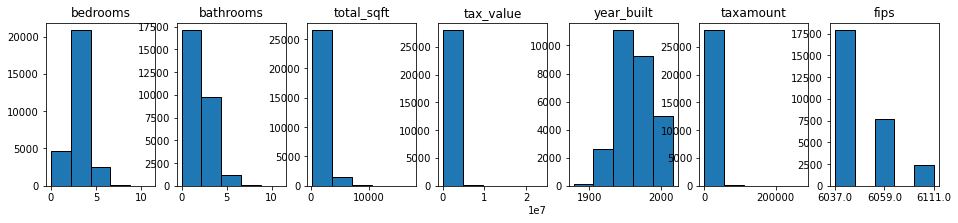

In [29]:
#vizualize the data so that we can get a better sense of how to handle values like outliers, if any.

plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms', 'total_sqft', 'tax_value', 'year_built', 'taxamount', 'fips']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,7, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    df[col].hist(bins=5, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)



In [30]:
#just by visually peeking at the data here are my takeaways:
# -most homes have fewer than 5 bedrooms
# -most homes have fewer than 5 bathrooms
# -most homes have fewer than 3000(approx) sqft 
# -most homes tax_value is lower than 1% (approx)
# -most homes are built after 1950(approx)
# -most homes have low tax_amount than high
# -most homes are in la_county

In [31]:
#handle outliers:

#Handle outliers to see if shape of data changes at all
#Using John Salas function:

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [32]:
k = 1.5
col_list = ['bedrooms', 'bathrooms', 'total_sqft', 'tax_value', 'taxamount', 'year_built']

df = remove_outliers(df, k, col_list)
df.head()

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county,tax_rate
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0,1,0,0,0.0128
1,11289917,2.0,3.0,1458,6037.0,261.0,1970,2319.90,136104.0,1,0,0,0.0170
2,11705026,1.0,2.0,1421,6037.0,261.0,1911,543.69,35606.0,1,0,0,0.0153
3,14269464,3.0,4.0,2541,6059.0,261.0,2003,9819.72,880456.0,0,1,0,0.0112
4,11446756,2.0,3.0,1491,6037.0,261.0,1955,1399.27,107110.0,1,0,0,0.0131


In [34]:
#sanity checking for nulls and shape
df.isnull().sum()

parcelid                 0
bathrooms                0
bedrooms                 0
total_sqft               0
fips                     0
propertylandusetypeid    0
year_built               0
taxamount                0
tax_value                0
la_county                0
orange_county            0
ventura_county           0
tax_rate                 0
dtype: int64

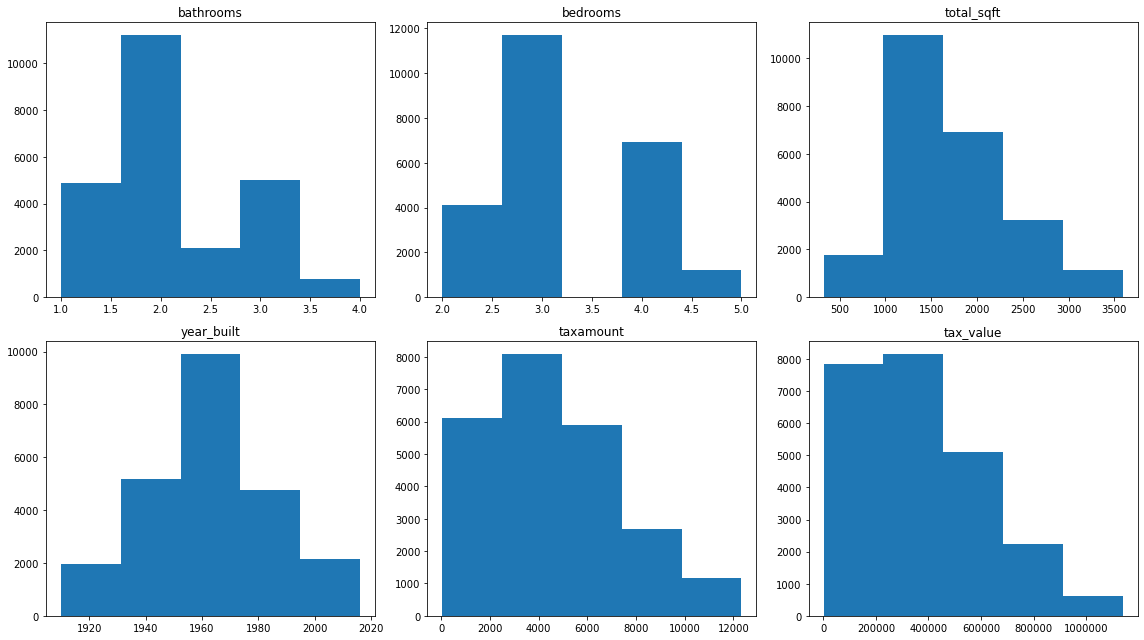

In [41]:
#now visualize now that outliers have been handled:
plt.figure(figsize=(16, 9))

# List of columns
cols = [col for col in df.columns if col not in ['propertylandusetypeid', 'parcelid','tax_rate', 'fips', 'la_county', 'orange_county', 'ventura_county']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2, (len(cols))/2, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(style='plain', useOffset=False)
    
    # mitigate overlap
    plt.tight_layout()
    
plt.show()

In [38]:
#takeaways after eliminating the outliers:

# - bedrooms have an odd distribution: would be normal except for the big gap between 3 and 4. 
# - bathrooms are not normally distributed
# - total_sqft and tax_value have a similar shape. this could be important later.
# - year_built appears normally distributed
# - tax_amount is not quite normal, but more normal than total_sqft and tax_value